In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx
import importlib
import quasibi
from tqdm import tqdm
importlib.reload(quasibi);

In [67]:
# load the correlation matrices
pearson = quasibi.load_symmat("../output/pearson_correlation_matrix.npy")
rmd     = quasibi.load_symmat("../output/rmd_correlation_matrix.npy")
D       = quasibi.load_symmat("../output/distance.npy")

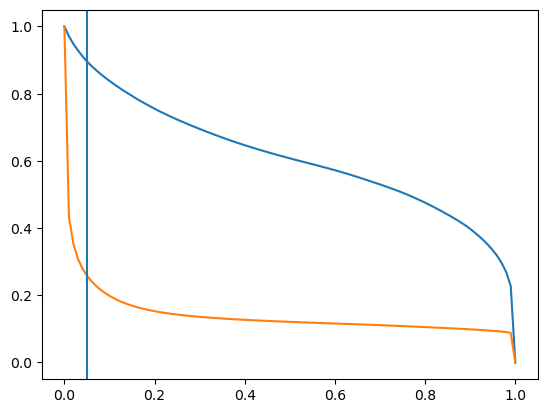

In [14]:
p = np.linspace(0, 1, 100)

plt.plot(p, np.quantile(pearson.flatten(), 1 - p)/np.max(pearson))
plt.plot(p, np.quantile(rmd.flatten(), 1 - p)/np.max(rmd))
plt.axvline(0.05)

In [31]:
def average_path_length(nx):
    lengths = np.array([np.trim_zeros(np.fromiter(x[1].values(), dtype="float32")).mean() for x in networkx.shortest_path_length(nx)])
    return np.nanmean(lengths)

In [59]:
np.errstate(all="ignore")

ps = np.linspace(0.2, 0, 50, endpoint=False)

M = np.zeros((len(ps), 2, 4))

for i, p in tqdm(enumerate(ps), total=len(ps)):
    
    # thresholded adjacency matrix
    pearson_threshold = np.abs(pearson) >= np.quantile(np.abs(pearson), 1 - p)
    rmd_threshold = np.abs(rmd) >= np.quantile(np.abs(rmd), 1 - p)
    
    # network
    pearson_net = networkx.from_numpy_matrix(pearson_threshold)
    rmd_net = networkx.from_numpy_matrix(rmd_threshold)
    
    # hamming distance
    M[i, :, 0] = np.mean(pearson_threshold ^ rmd_threshold)
    
    # average clustering coefficient
    M[i, 0, 1] = networkx.average_clustering(pearson_net)
    M[i, 1, 1] = networkx.average_clustering(rmd_net)
    
    # average path length
    M[i, 0, 2] = average_path_length(pearson_net)
    M[i, 1, 2] = average_path_length(rmd_net)
    
    # average degree connectivity
    M[i, 0, 3] = np.mean(np.fromiter(networkx.average_degree_connectivity(pearson_net).values(), "float32"))
    M[i, 1, 3] = np.mean(np.fromiter(networkx.average_degree_connectivity(rmd_net).values(), "float32"))
    
np.savez("../output/metrics/link_density", hamming=M[:,0,0], cluster=M[:,:,1], path_length=M[:,:,2], degree_connectivity=M[:,:,3])

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [10:31<00:08,  4.31s/it]D:\Users\David\AppData\Local\Temp\ipykernel_1372\701463014.py:2: RuntimeWarning: Mean of empty slice.
  lengths = np.array([np.trim_zeros(np.fromiter(x[1].values(), dtype="float32")).mean() for x in networkx.shortest_path_length(nx)])
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [10:35<00:00, 12.71s/it]


In [9]:
ps = np.linspace(0.2, 0, 50, endpoint=False)
H, CC, PL, DC = np.load("../output/metrics/link_density.npz").values()

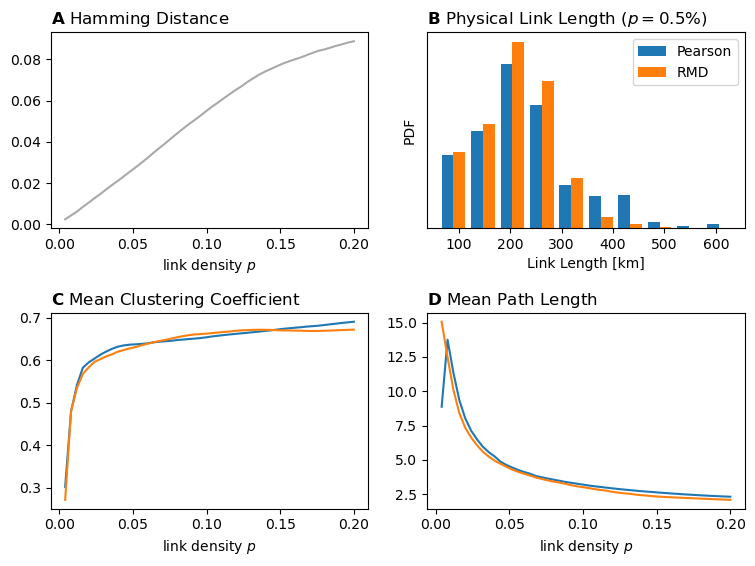

In [117]:
fig, axs = plt.subplots(2, 2, figsize=(1.2*6.4, 1.2*4.8))
axs = axs.flatten()

for i, (ax, m) in enumerate(zip(axs[[0,2,3]], (H, CC, PL))):

    ax.plot(ps, m, c="darkgray" if i==0 else None)
    ax.set_title(r"$\bf{" + ["A", "C", "D"][i] + "}$ " + ["Hamming Distance", "Mean Clustering Coefficient", "Mean Path Length"][i], loc="left")
    ax.set_xlabel("link density $p$")
        
# thresholded adjacency matrix
pearson_threshold = np.abs(pearson) >= np.quantile(np.abs(pearson), 1 - 0.005)
rmd_threshold = np.abs(rmd) >= np.quantile(np.abs(rmd), 1 - 0.005) 

counts, bins, _ = axs[1].hist([quasibi.link_distances(pearson_threshold, D), quasibi.link_distances(rmd_threshold, D)], density=True)
axs[1].legend(["Pearson", "RMD"])
axs[1].set_yticks([])
axs[1].set_ylabel("PDF")
axs[1].set_xlabel("Link Length [km]")
axs[1].set_title(r"$\bf{B}$ Physical Link Length ($p=0.5\%$)", loc="left")
    
plt.tight_layout()
plt.savefig("../plots/link_density.pdf", bbox_inches="tight")
plt.show()

PearsonRResult(statistic=7.546047120499111e-17, pvalue=0.9999999999999934)

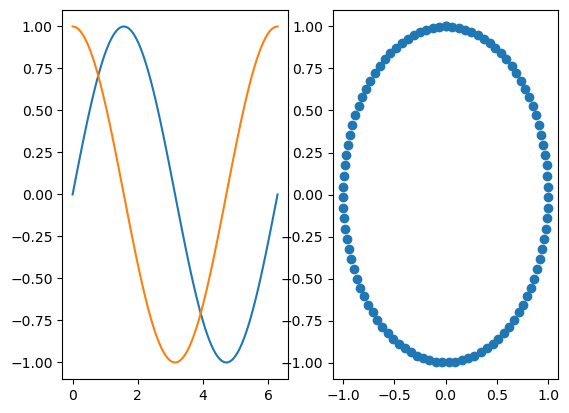

In [124]:
t = np.linspace(0, 2*np.pi, 100)
x = np.sin(t)
y = np.sin(t + np.pi/2)

plt.subplot(121)
plt.plot(t, x)
plt.plot(t, y)

plt.subplot(122)
plt.scatter(x, y)

import scipy as sp
sp.stats.pearsonr(x, y)